In [1]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch


class MNISTOneHot(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        data, target = self.mnist_dataset[idx]
        # ONe hot encoding
        target_one_hot = torch.zeros(10)
        target_one_hot[target] = 1
        return data, target_one_hot

#loading and converting mnist_dataset
transform = transforms.Compose([transforms.ToTensor(), ])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_dataset = Subset(mnist_dataset, range(8000))
mnist_one_hot = MNISTOneHot(mnist_dataset)

train_size = 5000
val_size = 1000
test_size = 2000
train_dataset, val_dataset, test_dataset = random_split(mnist_one_hot, [train_size, val_size, test_size])


# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_values = []

    for i in range(1,epoch+1):
        epoch_loss=0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)
        epoch_loss /= len(train_loader.dataset)
        loss_values.append(epoch_loss)

    # Plots
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 1), loss_values, label='Training Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def test(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()


    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, correct, len(val_loader.dataset), accuracy

# network A
class NetworkA(nn.Module):
    def __init__(self):
        super(NetworkA, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_a = NetworkA().to(device)

# DataLoaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)




100%|██████████| 9912422/9912422 [00:00<00:00, 177023380.93it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 11479880.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44372743.29it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6902365.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



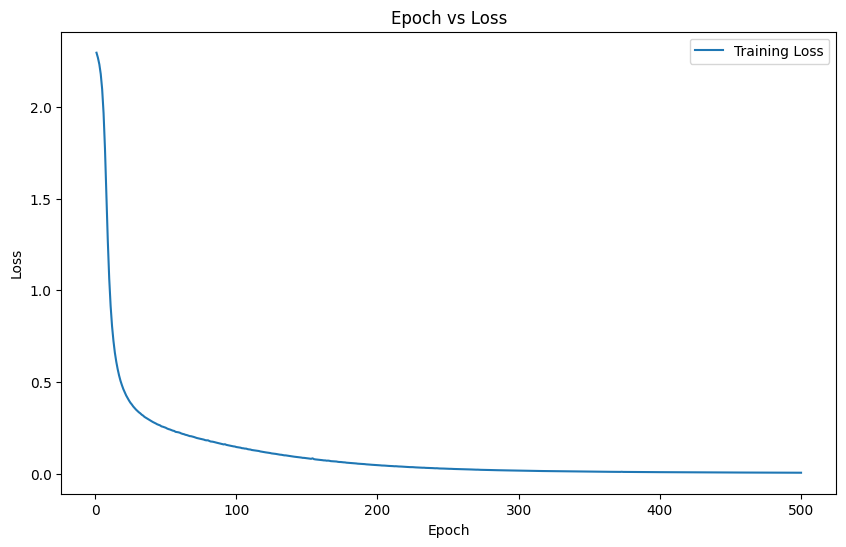


Validation set: Average loss: 0.2750, Accuracy: 947/1000 (95%)


Test set: Average loss: 0.3204, Accuracy: 1860/2000 (93%)



In [2]:
#momentum
class CustomMomentum:
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        self.params = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for p, v in zip(self.params, self.velocities):
            if p.grad is not None:
                v.mul_(self.momentum).add_(p.grad.data, alpha=(1 - self.momentum))
                p.data -= self.lr * v

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()




optimizer_a = CustomMomentum(model_a.parameters(), lr=0.01)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))


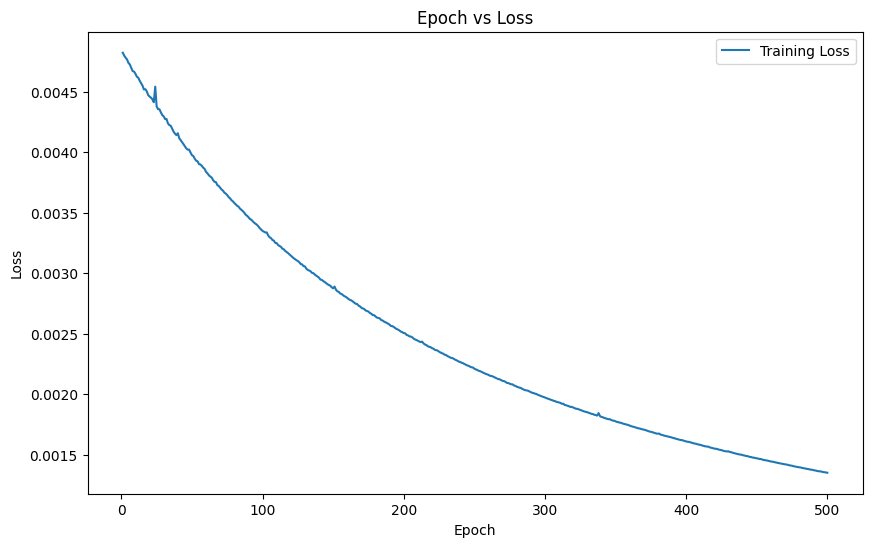


Validation set: Average loss: 0.3092, Accuracy: 948/1000 (95%)


Test set: Average loss: 0.3663, Accuracy: 1860/2000 (93%)



In [3]:
#momentum
class CustomMomentum:
    def __init__(self, parameters, lr=0.01, momentum=0.8):
        self.params = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for p, v in zip(self.params, self.velocities):
            if p.grad is not None:
                v.mul_(self.momentum).add_(p.grad.data, alpha=(1 - self.momentum))
                p.data -= self.lr * v

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()




optimizer_a = CustomMomentum(model_a.parameters(), lr=0.01)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))


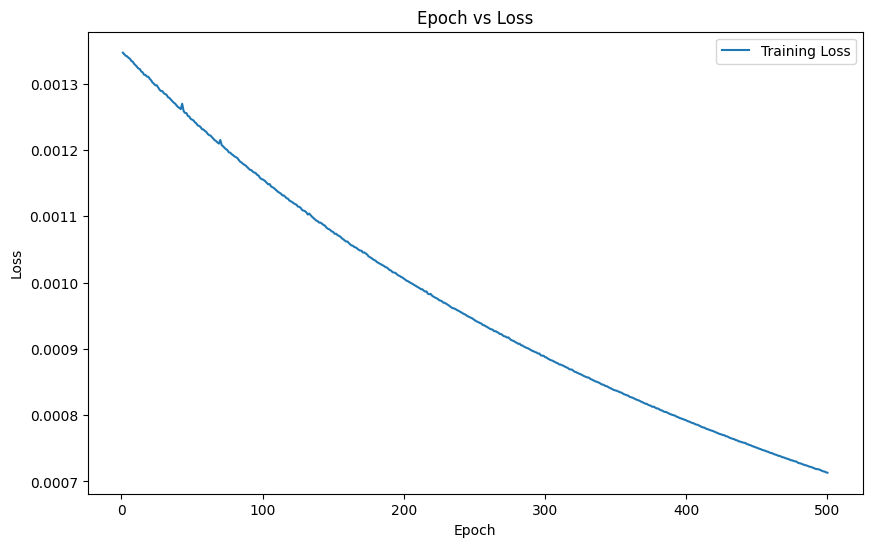


Validation set: Average loss: 0.3279, Accuracy: 948/1000 (95%)


Test set: Average loss: 0.3900, Accuracy: 1861/2000 (93%)



In [4]:
#momentum
class CustomMomentum:
    def __init__(self, parameters, lr=0.1, momentum=0.9):
        self.params = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for p, v in zip(self.params, self.velocities):
            if p.grad is not None:
                v.mul_(self.momentum).add_(p.grad.data, alpha=(1 - self.momentum))
                p.data -= self.lr * v

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()




optimizer_a = CustomMomentum(model_a.parameters(), lr=0.01)

train(model_a, device, train_loader, optimizer_a, 500)

val_loss, correct, x, accuracy = test(model_a, device, val_loader)
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, x, accuracy))

#for testing
test_loss, correct, x, accuracy  = test(model_a, device, test_loader)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, x, accuracy))
